In [1]:
%cd ../..

C:\Users\fahmi\Documents\Github ML Project\time-series-projects


# Load Libraries & Dataset

In [2]:
import pandas as pd
import numpy as np
import os
import joblib

from src.utils.general import LogTime
from src.feature_engineering.autoregressive_features import (
    add_lags,
    add_rolling_features,
    add_seasonal_rolling_features,
    add_ewma,
)
from src.feature_engineering.temporal_features import (
    add_temporal_features,
    bulk_add_fourier_features
)

from src.transforms.target_transformations import AutoStationaryTransformer

C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\utils\data_utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
energy = pd.read_csv('energy-consumption/datasets/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']
energy.index.freq = 'MS'
energy

,y
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326
...,...
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799


In [4]:
energy.describe()

,y
count,588.000000
mean,1551.824029
std,403.939753
min,901.700000
25%,1251.331250
50%,1466.218500
75%,1810.309750
max,2808.412000


In [5]:
energy.isnull().sum()

y    0
dtype: int64

# Feature Engineering
## Feature Lags

In [6]:
lags = (
    (np.arange(6) + 1).tolist()
    + (np.arange(6) + 12).tolist()
)

lags

[1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17]

In [7]:
with LogTime():
    energy, added_features = add_lags(
        energy, lags=lags, column="y", ts_id=None, use_32_bit=True
    )
    
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 0 microseconds
Features Created: y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_12,y_lag_13,y_lag_14,y_lag_15,y_lag_16,y_lag_17


C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\feature_engineering\autoregressive_features.py:66: UserWarning: Assuming just one unique time series in dataset. If there are multiple, provide `ts_id` argument
  warnings.warn(


## Rolling

In [8]:
with LogTime():
    energy, added_features = add_rolling_features(
        energy,
        rolls=[3, 6, 9, 12],
        column="y",
        agg_funcs=["mean", "std"],
        ts_id=None,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 0 microseconds
Features Created: y_rolling_3_mean,y_rolling_3_std,y_rolling_6_mean,y_rolling_6_std,y_rolling_9_mean,y_rolling_9_std,y_rolling_12_mean,y_rolling_12_std


C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\feature_engineering\autoregressive_features.py:149: UserWarning: Assuming just one unique time series in dataset. If there are multiple, provide `ts_id` argument
  warnings.warn(


## EWMA

In [9]:
with LogTime():
    energy, added_features = add_ewma(energy, alphas=[0.3, 0.5, 0.8], column="y", ts_id=None, use_32_bit=False)
#     full_df, added_features = add_ewma(
#         full_df,
#         spans=[48 * 60, 48 * 7, 48],
#         column="y",
#         ts_id=None,
#         use_32_bit=True,
#     )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 0 microseconds
Features Created: y_ewma_alpha_0.3,y_ewma_alpha_0.5,y_ewma_alpha_0.8


C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\feature_engineering\autoregressive_features.py:359: UserWarning: Assuming just one unique time series in dataset. If there are multiple, provide `ts_id` argument
  warnings.warn(


## Temporal Embedding

In [10]:
with LogTime():
    energy, added_features = add_temporal_features(
        energy.reset_index(),
        field_name="Month",
        frequency="MS",
        add_elapsed=True,
        drop=False,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 0 microseconds
Features Created: Month_Month,Month_Quarter,Month_Is_quarter_end,Month_Is_quarter_start,Month_Is_year_end,Month_Is_year_start,Month_Elapsed


## Fourier Terms

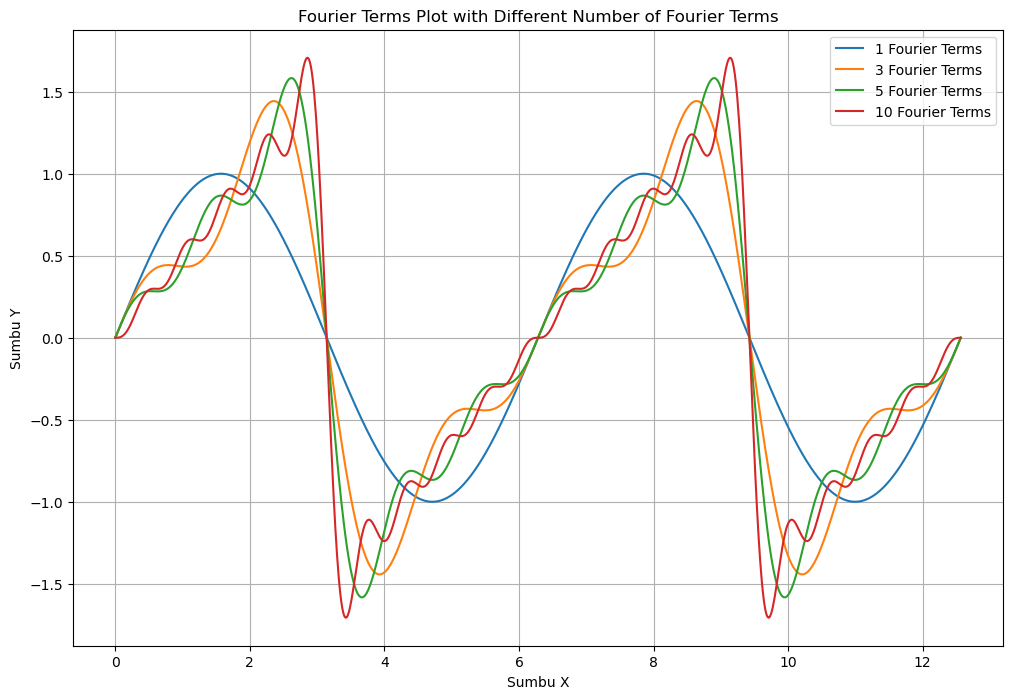

In [11]:
import matplotlib.pyplot as plt

# Function to determine Fourier Series
def fourier_series(x, num_terms):
    series = np.zeros_like(x, dtype=np.float64)
    for i in range(1, num_terms + 1):
        if i % 2 == 0:
            series -= (1 / i) * np.sin(i * x)
        else:
            series += (1 / i) * np.sin(i * x)
    return series

# Input data
x = np.linspace(0, 4 * np.pi, 1000)

# list of fourier terms
num_terms_list = [1, 3, 5, 10]

# Plotting for each fourier terms
plt.figure(figsize=(12, 8))
for num_terms in num_terms_list:
    y = fourier_series(x, num_terms)
    plt.plot(x, y, label=f'{num_terms} Fourier Terms')

plt.title('Fourier Terms Plot with Different Number of Fourier Terms')
plt.xlabel('Sumbu X')
plt.ylabel('Sumbu Y')
plt.legend()
plt.grid()
plt.show()


In [12]:
with LogTime():
    energy, added_features = bulk_add_fourier_features(
        energy,
        ["Month_Month", "Month_Quarter"],
        max_values=[12, 4],
        n_fourier_terms=6,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 0 microseconds
Features Created: Month_Month_sin_1,Month_Month_sin_2,Month_Month_sin_3,Month_Month_sin_4,Month_Month_sin_5,Month_Month_sin_6,Month_Month_cos_1,Month_Month_cos_2,Month_Month_cos_3,Month_Month_cos_4,Month_Month_cos_5,Month_Month_cos_6,Month_Quarter_sin_1,Month_Quarter_sin_2,Month_Quarter_sin_3,Month_Quarter_sin_4,Month_Quarter_sin_5,Month_Quarter_sin_6,Month_Quarter_cos_1,Month_Quarter_cos_2,Month_Quarter_cos_3,Month_Quarter_cos_4,Month_Quarter_cos_5,Month_Quarter_cos_6


In [13]:
energy.columns

Index(['Month', 'y', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5',
       'y_lag_6', 'y_lag_12', 'y_lag_13', 'y_lag_14', 'y_lag_15', 'y_lag_16',
       'y_lag_17', 'y_rolling_3_mean', 'y_rolling_3_std', 'y_rolling_6_mean',
       'y_rolling_6_std', 'y_rolling_9_mean', 'y_rolling_9_std',
       'y_rolling_12_mean', 'y_rolling_12_std', 'y_ewma_alpha_0.3',
       'y_ewma_alpha_0.5', 'y_ewma_alpha_0.8', 'Month_Month', 'Month_Quarter',
       'Month_Is_quarter_end', 'Month_Is_quarter_start', 'Month_Is_year_end',
       'Month_Is_year_start', 'Month_Elapsed', 'Month_Month_sin_1',
       'Month_Month_sin_2', 'Month_Month_sin_3', 'Month_Month_sin_4',
       'Month_Month_sin_5', 'Month_Month_sin_6', 'Month_Month_cos_1',
       'Month_Month_cos_2', 'Month_Month_cos_3', 'Month_Month_cos_4',
       'Month_Month_cos_5', 'Month_Month_cos_6', 'Month_Quarter_sin_1',
       'Month_Quarter_sin_2', 'Month_Quarter_sin_3', 'Month_Quarter_sin_4',
       'Month_Quarter_sin_5', 'Month_Quarter_sin_6',

In [14]:
pd.set_option("display.max_rows", None)

energy

,Month,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_12,y_lag_13,...,Month_Quarter_sin_3,Month_Quarter_sin_4,Month_Quarter_sin_5,Month_Quarter_sin_6,Month_Quarter_cos_1,Month_Quarter_cos_2,Month_Quarter_cos_3,Month_Quarter_cos_4,Month_Quarter_cos_5,Month_Quarter_cos_6
0,1973-01-01,1957.641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.000000e+00,-2.449294e-16,1.000000e+00,3.673940e-16,6.123234e-17,-1.0,-1.836970e-16,1.0,3.061617e-16,-1.0
1,1973-02-01,1712.143,1957.640991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.000000e+00,-2.449294e-16,1.000000e+00,3.673940e-16,6.123234e-17,-1.0,-1.836970e-16,1.0,3.061617e-16,-1.0
2,1973-03-01,1510.079,1712.142944,1957.640991,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.000000e+00,-2.449294e-16,1.000000e+00,3.673940e-16,6.123234e-17,-1.0,-1.836970e-16,1.0,3.061617e-16,-1.0
3,1973-04-01,1183.421,1510.078979,1712.142944,1957.640991,NaN,NaN,NaN,NaN,NaN,...,3.673940e-16,-4.898587e-16,6.123234e-16,-7.347881e-16,-1.000000e+00,1.0,-1.000000e+00,1.0,-1.000000e+00,1.0
4,1973-05-01,1006.326,1183.421021,1510.078979,1712.142944,1957.640991,NaN,NaN,NaN,NaN,...,3.673940e-16,-4.898587e-16,6.123234e-16,-7.347881e-16,-1.000000e+00,1.0,-1.000000e+00,1.0,-1.000000e+00,1.0
5,1973-06-01,914.949,1006.325989,1183.421021,1510.078979,1712.142944,1957.640991,NaN,NaN,NaN,...,3.673940e-16,-4.898587e-16,6.123234e-16,-7.347881e-16,-1.000000e+00,1.0,-1.000000e+00,1.0,-1.000000e+00,1.0
6,1973-07-01,961.872,914.948975,1006.325989,1183.421021,1510.078979,1712.142944,1957.640991,NaN,NaN,...,1.000000e+00,-7.347881e-16,-1.000000e+00,1.102182e-15,-1.836970e-16,-1.0,5.510911e-16,1.0,-2.694842e-15,-1.0
7,1973-08-01,994.259,961.872009,914.948975,1006.325989,1183.421021,1510.078979,1712.142944,NaN,NaN,...,1.000000e+00,-7.347881e-16,-1.000000e+00,1.102182e-15,-1.836970e-16,-1.0,5.510911e-16,1.0,-2.694842e-15,-1.0
8,1973-09-01,937.083,994.258972,961.872009,914.948975,1006.325989,1183.421021,1510.078979,NaN,NaN,...,1.000000e+00,-7.347881e-16,-1.000000e+00,1.102182e-15,-1.836970e-16,-1.0,5.510911e-16,1.0,-2.694842e-15,-1.0
9,1973-10-01,978.162,937.083008,994.258972,961.872009,914.948975,1006.325989,1183.421021,NaN,NaN,...,-7.347881e-16,-9.797175e-16,-1.224647e-15,-1.469576e-15,1.000000e+00,1.0,1.000000e+00,1.0,1.000000e+00,1.0


# Splitting Data

In [15]:
def split_data(data, train_split, val_split, test_split):
    l = len(data)
    train_idx = round(l * train_split)
    val_idx = round(l * (train_split + val_split))
    
    train, val, test = data[:train_idx], data[train_idx:val_idx], data[val_idx:]
    
    print(f'train: {len(train)}, val: {len(val)}, test: {len(test)}')
    
    return train, val, test

In [16]:
train_data, val_data, test_data = split_data(energy, 0.7, 0.15, 0.15)

train: 412, val: 88, test: 88


# Transforming Target Features

In [17]:
train_data["type"] = "train"
val_data["type"] = "val"
test_data["type"] = "test"

In [18]:
train_val_data = pd.concat([train_data,val_data])

In [19]:
#Initialize the AutoStationaryTransformer with a seasonality period of 12
auto_stationary = AutoStationaryTransformer(seasonal_period=12)
#Creating the timeseries with datetime index
y = train_val_data.loc[:, ["y","Month"]].set_index("Month")
#Fitting and trainsforming the train
y_stat = auto_stationary.fit_transform(y, freq="MS")
# Setting the transformerd series back to the dataframe
train_val_data.loc[:, "y"] = y_stat.values
train_val_data = train_val_data.loc[:, ["Month", "y"]]
train_val_data.rename(columns={"y":"y_auto_stat"}, inplace=True)
train_val_data

C:\Users\fahmi\Documents\Github ML Project\time-series-projects\src\decomposition\seasonal.py:36: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return lambda x: X.__class__(x, index=index, name=names)


,Month,y_auto_stat
0,1973-01-01,383.321076
1,1973-02-01,430.935201
2,1973-03-01,430.898157
3,1973-04-01,470.959193
4,1973-05-01,452.944498
5,1973-06-01,348.743209
6,1973-07-01,253.303422
7,1973-08-01,283.554177
8,1973-09-01,383.943581
9,1973-10-01,428.684578


# Save Preprocessed Data

In [20]:
os.makedirs("energy-consumption/datasets/preprocessed/", exist_ok=True)
os.makedirs("energy-consumption/datasets/autotransform/", exist_ok=True)

In [21]:
train_data.to_csv("energy-consumption/datasets/preprocessed/train_data_preprocessed.csv", index=False)
val_data.to_csv("energy-consumption/datasets/preprocessed/val_data_preprocessed.csv", index=False)
test_data.to_csv("energy-consumption/datasets/preprocessed/test_data_preprocessed.csv", index=False)

joblib.dump(auto_stationary, "energy-consumption/datasets/preprocessed/train_val_data_autotransformer_pipeline.pkl")
train_val_data.to_csv("energy-consumption/datasets/autotransform/train_val_data_autotransformer.csv", index=False)